In [1]:
import os

import numpy as np

import torch
import torchvision
from torchvision.io import read_image

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import ignite

from piq import BRISQUELoss, TVLoss, brisque, ssim, psnr

import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm

from utils import loss_history, plot_history

%matplotlib inline

In [2]:
path_img = './data/RealSR(V3)/canon/train/2'
images_lr = []
images_hr = []

for filename in os.listdir(path_img):
    if filename.find('LR')>0:
        images_lr.append(read_image(os.path.join(path_img, filename)).type(torch.FloatTensor))
    else:
        images_hr.append(read_image(os.path.join(path_img, filename)).type(torch.FloatTensor))

path_img = './data/RealSR(V3)/canon/test/2'
images_lr_test = []
images_hr_test = []

for filename in os.listdir(path_img):
    if filename.find('LR')>0:
        images_lr_test.append(read_image(os.path.join(path_img, filename)))
    else:
        images_hr_test.append(read_image(os.path.join(path_img, filename)))
        

In [3]:
images_lr_downscales = []
scale = 2
for image in images_lr:
    resize = torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)))
    image_downscale = resize(image)
    images_lr_downscales.append(image_downscale)
    
images_lr_downscales_test = []
scale = 2
for image in images_lr_test:
    resize = torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)))
    image_downscale = resize(image)
    images_lr_downscales_test.append(image_downscale)    

C:\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [4]:
class images_dataset(Dataset):
    def __init__(self, data_source, data_target):
        self.data_source = data_source
        self.data_target = data_target
        
    def __len__(self):
        return len(self.data_source)
    
    def __getitem__(self, index):
        data_source = self.data_source[index]
        data_target = self.data_target[index]
        return data_source, data_target

In [5]:
def collate_fn(batch):
    data_source = torch.LongTensor([item[0] for item in batch])
    data_target = torch.LongTensor([item[1] for item in batch])
    return data_source, data_target

In [96]:
class torch_trainer():
    
    def __init__(self, model, criterion, optimizer, epochs, dataloader, device='cuda', scheduler=None, metrics=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.dataloader = dataloader
        self.device = device
        self.history = loss_history()
        self.metrics = metrics
        
    
        
    def train(self):

        self.history.clear()
        loss = 0
        val_loss = 0

        for epoch in range(self.epochs):

            epoch_loss = []
            epoch_val_loss = []
            items = len(self.dataloader['train'])

            self.model.train()
            item=1
            for batch in self.dataloader['train']:
                self.optimizer.zero_grad()
                data = batch[0].to(device)
                preds = self.model(data).type(torch.FloatTensor)
                target = batch[1].to(device).type(torch.FloatTensor)
                loss = self.criterion(preds, target)
                loss.backward()
                epoch_loss.append(loss.numpy(force=True))
                self.optimizer.step()
                print (f'epoch {epoch+1}/{self.epochs}... {item}/{items}: train loss: {loss:.4f}, val_loss: {val_loss:.4f}', end='\r')
                item+=1

            items = len(self.dataloader['test'])
            self.model.eval()
            item=1
            with torch.no_grad():
                for batch in self.dataloader['test']:
                    data = batch[0].to(device)
                    preds = self.model(data)
                    target = batch[1].to(device)
                    val_loss = self.criterion(preds, target)
                    epoch_val_loss.append(val_loss.numpy(force=True))
                    print (f'epoch {epoch+1}/{self.epochs}... {item}/{items}: train loss: {loss:.4f}, val_loss: {val_loss:.4f}', end='\r')
                    item+=1
               
            loss = np.array(epoch_loss).mean()
            val_loss = np.array(epoch_val_loss).mean()

            if scheduler:
                scheduler.step(loss)
                
            if self.metrics:
                metric = self.metrics(preds, target)
            
            self.history.loss.append(loss)
            self.history.val_loss.append(val_loss)
            lr = optimizer.param_groups[0]["lr"]

            print (f'epoch {epoch+1}/{self.epochs}; train loss: {loss:.4f}, val_loss: {val_loss:.4f}; lr={lr};  metric={metric:.4f}', end='\n')

        return self.history

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print (device) 

cuda


In [8]:
def plot_history(history):
    plt.plot(history.loss, label='train loss')
    plt.plot(history.val_loss, label='val loss')
    plt.legend()
    plt.show()

# deblur

In [134]:
class nn_deblur(nn.Module):
    def __init__(self, n_channels):
        super(nn_deblur, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(3,3), stride=1, padding='same'),
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(5,5), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(7,7), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(11,11), stride=1, padding='same')
        )
        self.conv_resc1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
        
        #self.conv2 = nn.Sequential(
        #    nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(3,3), stride=1, padding='same'),
        #    nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(5,5), stride=1, padding='same'),
        #    nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(7,7), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(11,11), stride=1, padding='same')
        #)
        #self.conv_resc2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
        
        self.act = nn.GELU()
        
    def forward(self, x):
        x = x.type(torch.cuda.FloatTensor)
        x = self.conv1(x) + self.conv_resc1(x)
        #x = self.conv2(x) + self.conv_resc2(x)
        x = self.act(x)
        x = torch.clamp(x, min=0, max=255)
        return x

In [44]:
class nn_deblur_v3(nn.Module):
    def __init__(self, n_channels):
        super(nn_deblur_v3, self).__init__()
        
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(1,1), padding='same'),
            nn.GELU()
        )
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(3,3), padding='same'),
            nn.GELU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(5,5), padding='same'),
            nn.GELU()
        )
        
        self.conv_resc = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(1,1), padding='same')
        
        self.conv_out = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(1,1), padding='same'),
            nn.GELU()
        ) 
                       
    def forward(self, x):
        x0 = x.type(torch.cuda.FloatTensor)
        x0 = self.conv_in(x0)
        
        x = self.conv1(x0) + self.conv2(x0)        
        x = x0 + self.conv_resc(x)

        x = self.conv_out(x)

        x = torch.clamp(x, min=0, max=255)
        return x

In [13]:
class nn_deblur_v1(nn.Module):
    def __init__(self, n_channels):
        super(nn_deblur_v1, self).__init__()
        
        self.conv_in = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), stride=1, padding='same')
        
        self.conv3x3 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=1, padding='same')
        self.conv5x5 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(5,5), stride=1, padding='same')
        #self.conv7x7 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(7,7), stride=1, padding='same')
        #self.conv11x11 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(11,11), stride=1, padding='same')
        
        self.conv_out = nn.Conv2d(in_channels=6, out_channels=3, kernel_size=(1,1), stride=1, padding='same')
        self.conv_resc1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
        
        self.act = nn.GELU()
        
    def forward(self, x):
        x = x.type(torch.cuda.FloatTensor)
        x_input = x
        #x = self.conv_in(x)
        
        x_3x3 = self.conv3x3(x)
        x_5x5 = self.conv5x5(x)
        #x_7x7 = self.conv7x7(x)
        #x_11x11 = self.conv11x11(x)
        
        x = torch.cat((x_3x3, x_5x5), 1) #, x_7x7, x_11x11), 1)

        x = self.conv_out(x) + self.conv_resc1(x_input)
        x = self.act(x)
        x = torch.clamp(x, min=0, max=255)

        return x

In [9]:
ds_deblur_train = images_dataset(images_lr[:1], images_lr[:1])
ds_deblur_test = images_dataset(images_lr_test[:1], images_lr_test[:1])

BATCH_SIZE = 1

dl_deblur_train = DataLoader(ds_deblur_train,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
dl_deblur_test = DataLoader(ds_deblur_test,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

dl_deblur = {'train': dl_deblur_train, 'test': dl_deblur_test}

ds_deblur_withscale = images_dataset(images_lr_downscales[:10], images_lr[:10])
dl_deblur_withscale = DataLoader(ds_deblur_withscale,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

dl_deblur_withscale = {'train': dl_deblur, 'test': dl_deblur_test}

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print (device) 

cuda


In [ ]:
class loss_search():
    def __init__(self, tv_coef=10000, l1_coef=0.01):
        super(loss_search, self).__init__()
        self.tv_coeff = tv_coef
        self.l1_coeff = l1_coef
    def forward(self, y_pred, y_true):
        loss = TVLoss()(y_pred)
        loss = self.tv_coef/loss + self.l1_coef*nn.L1Loss()(y_pred, y_true)
        return loss

def loss_tv(y_pred, y_true, tv_coeff=10000, l1_coeff=0.01):
    loss = TVLoss()(y_pred)
    loss = 10000/loss + 0.01*nn.L1Loss()(y_pred, y_true)
    return loss


grid_search_results = []

tv_coeffs = [2500, 5000, 7500, 10000, 12500, 15000]
l1_coeffs = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
epochs = [2000, 3000, 4000, 5000]

test = read_image('out_before.png')
test = test[None, :]
ref = images_hr[0]
ref = ref[None, :]

for tv_coeff in tqdm(tv_coeffs):
    for l1_coeff in tqdm(l1_coeffs):
        for epoch in tqdm(epochs):
            model = nn_deblur_v1(3)
            model = model.to(device)
            optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,min_lr=1e-7)
            print (model)
            print('-------')
            print (f'starting tv={tv_coeff}, l1={l1_coeff}, epoch={epoch}')
            loss = loss_search(tv_coeff, l1_coeff)
            criterion = loss
            optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)          
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,min_lr=1e-5)            
            trainer = torch_trainer(model=model,
                                   criterion=criterion_deblur,
                                   optimizer=optimizer,
                                   epochs=epoch,
                                   dataloader=dl_deblur)
            history = trainer.train()
            model.eval()
            with torch.no_grad():
                preds = model(test).type(torch.LongTensor)
            img = preds[0].permute(1,2,0).detach()
            ssim_after = ssim(preds, ref, data_range=255)
            grid_search_result = {'tv_coeff': tv_coeff,
                                 'l1_coeff': l1_coeff,
                                 'epochs': epoch,
                                 'history': history,
                                 'ssim': ssim_after}
            grid_search_results.append(grid_search_result)
            plot_history(history)
            plt.imshow(img)
            print(grid_search_result)
            print('==========================================')

In [28]:
grid_search_results

[{'tv_coeff': 2500,
  'l1_coeff': 0.0001,
  'epochs': 2000,
  'history': <utils.loss_history at 0x22b7ce4ad00>,
  'ssim': tensor(0.8032)},
 {'tv_coeff': 2500,
  'l1_coeff': 0.0001,
  'epochs': 3000,
  'history': <utils.loss_history at 0x22d0493f910>,
  'ssim': tensor(0.9026)},
 {'tv_coeff': 2500,
  'l1_coeff': 0.0001,
  'epochs': 4000,
  'history': <utils.loss_history at 0x22d04829eb0>,
  'ssim': tensor(0.5923)},
 {'tv_coeff': 2500,
  'l1_coeff': 0.0001,
  'epochs': 5000,
  'history': <utils.loss_history at 0x22d048b2f70>,
  'ssim': tensor(0.8837)},
 {'tv_coeff': 2500,
  'l1_coeff': 0.0005,
  'epochs': 2000,
  'history': <utils.loss_history at 0x22d053470d0>,
  'ssim': tensor(0.9036)},
 {'tv_coeff': 2500,
  'l1_coeff': 0.0005,
  'epochs': 3000,
  'history': <utils.loss_history at 0x22d0580dfa0>,
  'ssim': tensor(0.8915)},
 {'tv_coeff': 2500,
  'l1_coeff': 0.0005,
  'epochs': 4000,
  'history': <utils.loss_history at 0x22d056ba490>,
  'ssim': tensor(0.8962)},
 {'tv_coeff': 2500,
  'l1_c

In [116]:
import pickle

with open('grid_search_results_v1', 'wb') as f:
    pickle.dump(grid_search_results, f)

In [117]:
#with open('grid_search_results_v1', 'rb') as f:
#     data = pickle.load(f)

In [34]:
for item in grid_search_results:
    results.append(np.array([item['tv_coeff'], item['l1_coeff'], item['epochs'], item['ssim']]))
results = np.array(results)

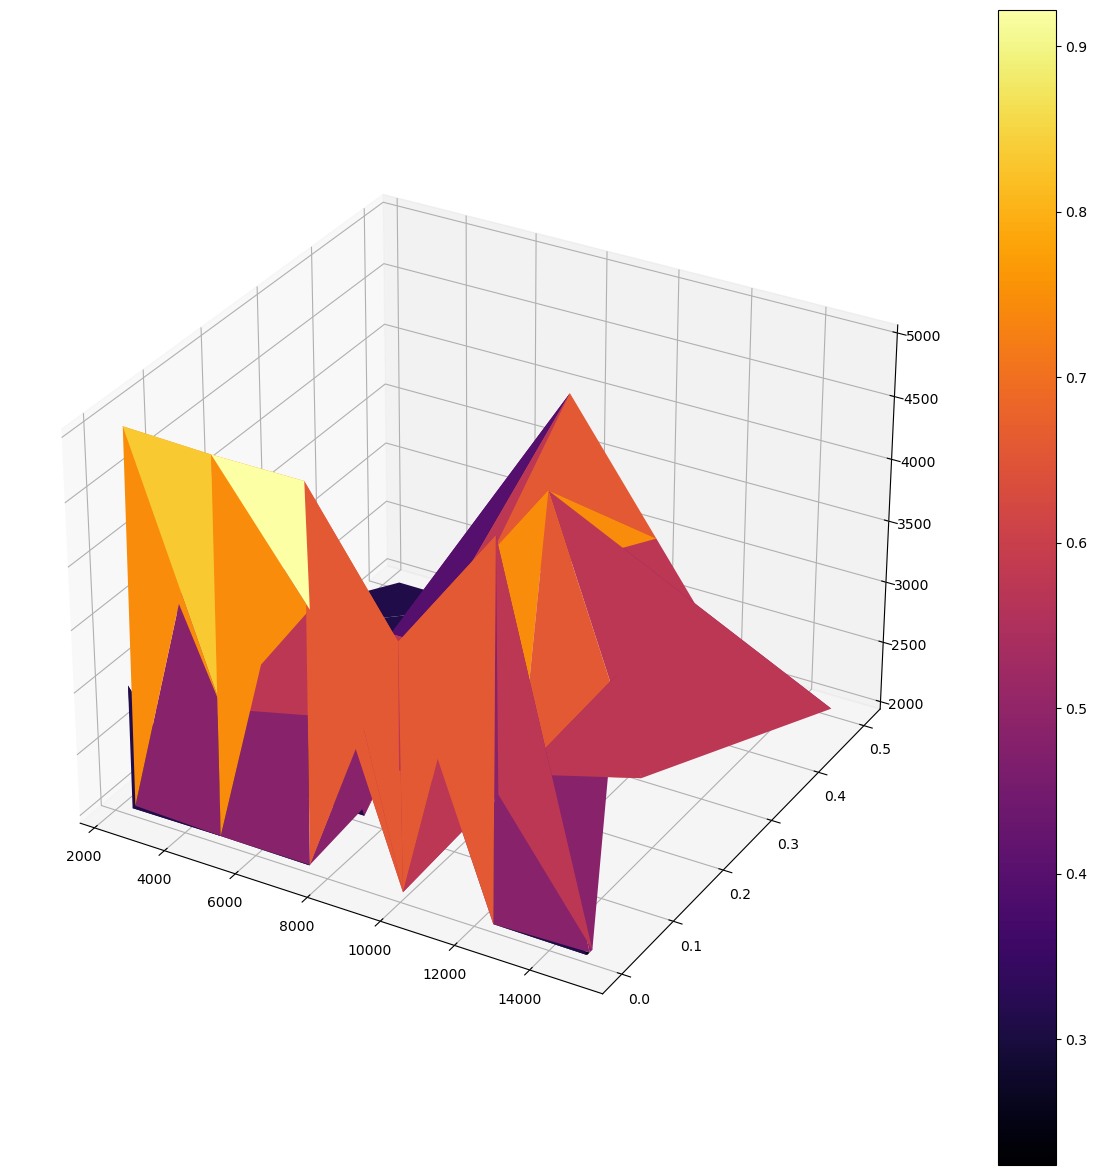

In [115]:
#from mpl_toolkits.mplot3d.axes3d import view_init

tv = results[:,0]
l1 = results[:,1]
epochs = results[:,2]
ssim = results[:,3]

fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection="3d")

# Creating plot
#ax.scatter3D(tv, l1, epochs, c=ssim, cmap=plt.hot())
scamap = plt.cm.ScalarMappable(cmap='inferno')
fcolors = scamap.to_rgba(ssim)
ax.plot_trisurf(tv, l1, epochs, facecolors=fcolors, cmap='inferno')
fig.colorbar(scamap)

plt.show()


In [110]:
np.argmax(results[:,3])

67

In [90]:
grid_search_results[67]

{'tv_coeff': 7500,
 'l1_coeff': 0.0001,
 'epochs': 5000,
 'history': <utils.loss_history at 0x22d06fcab20>,
 'ssim': tensor(0.9220)}

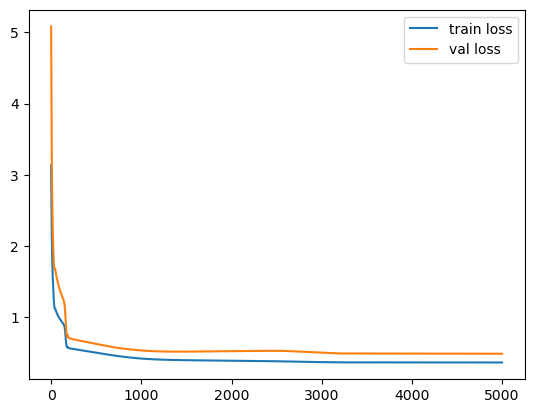

In [95]:
plot_history((grid_search_results[67])['history'])

In [17]:
model = nn_deblur_v1(8)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,min_lr=1e-7)
print (model)
loss = loss_search(7500, 0.0001)
criterion = loss
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)          
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,min_lr=1e-5)            
trainer = torch_trainer(model=model,
                                   criterion=criterion_deblur,
                                   optimizer=optimizer,
                                   epochs=5000,
                                   dataloader=dl_deblur)
history = trainer.train()

NameError: name 'nn_deblur_v1' is not defined

tensor(0.9090) tensor(0.9263)


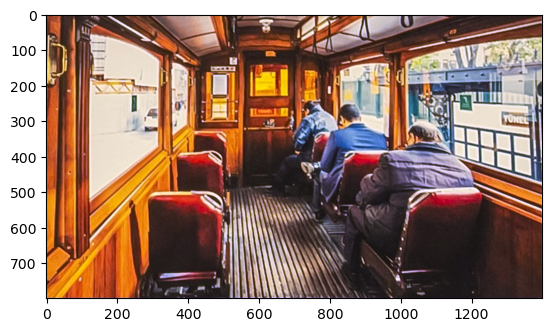

In [99]:
#test = images_lr[0]
test = read_image('out_before.png')
test = test[None, :]
model.eval()
with torch.no_grad():
    preds = model(test).type(torch.LongTensor)
img = preds[0].permute(1,2,0).detach()
to_save = (preds[0])/255.
torchvision.utils.save_image(to_save, 'out.png')
plt.imshow(img)

ref = images_hr[0]
ref = ref[None, :]
ssim_after = ssim(preds, ref, data_range=255)
ssim_before = ssim(test, ref, data_range=255)
print(ssim_after, ssim_before)

# *************

In [ ]:
class loss_search():
    def __init__(self, tv_coef=10000, l1_coef=0.01):
        super(loss_search, self).__init__()
        self.tv_coeff = tv_coef
        self.l1_coeff = l1_coef
    def forward(self, y_pred, y_true):
        loss = TVLoss()(y_pred)
        loss = self.tv_coef/loss + self.l1_coef*nn.L1Loss()(y_pred, y_true)
        return loss

def loss_tv(y_pred, y_true, tv_coeff=10000, l1_coeff=0.01):
    loss = TVLoss()(y_pred)
    loss = 10000/loss + 0.01*nn.L1Loss()(y_pred, y_true)
    return loss


grid_search_results = []

tv_coeffs = [7500, 10000, 12500]
l1_coeffs = [0.00001, 0.0001, 0.001, 0.01]
epochs = [3000, 4000, 5000]

test = read_image('out_before.png')
test = test[None, :]
ref = images_hr[0]
ref = ref[None, :]

for tv_coeff in tqdm(tv_coeffs):
    for l1_coeff in tqdm(l1_coeffs):
        for epoch in tqdm(epochs):
            model = nn_deblur(3)
            model = model.to(device)
            print (model)
            print('-------')
            print (f'starting tv={tv_coeff}, l1={l1_coeff}, epoch={epoch}')
            loss = loss_search(tv_coeff, l1_coeff)
            criterion = loss
            optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)          
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,min_lr=1e-7)            
            trainer = torch_trainer(model=model,
                                   criterion=criterion_deblur,
                                   optimizer=optimizer,
                                   epochs=epoch,
                                   dataloader=dl_deblur)
            history = trainer.train()
            model.eval()
            with torch.no_grad():
                preds = model(test).type(torch.LongTensor)
            img = preds[0].permute(1,2,0).detach()
            ssim_after = ssim(preds, ref, data_range=255)
            grid_search_result = {'tv_coeff': tv_coeff,
                                 'l1_coeff': l1_coeff,
                                 'epochs': epoch,
                                 'history': history,
                                 'ssim': ssim_after}
            grid_search_results.append(grid_search_result)
            plot_history(history)
            plt.imshow(img)
            print(grid_search_result)
            print('==========================================')

In [128]:
with open('grid_search_results', 'wb') as f:
    pickle.dump(grid_search_results, f)

In [130]:
results = []
for item in grid_search_results:
    results.append(np.array([item['tv_coeff'], item['l1_coeff'], item['epochs'], item['ssim']]))
results = np.array(results)

In [131]:
np.argmax(results[:,3])

17

In [132]:
grid_search_results[17]

{'tv_coeff': 10000,
 'l1_coeff': 0.0001,
 'epochs': 5000,
 'history': <utils.loss_history at 0x22d07a889a0>,
 'ssim': tensor(0.9310)}

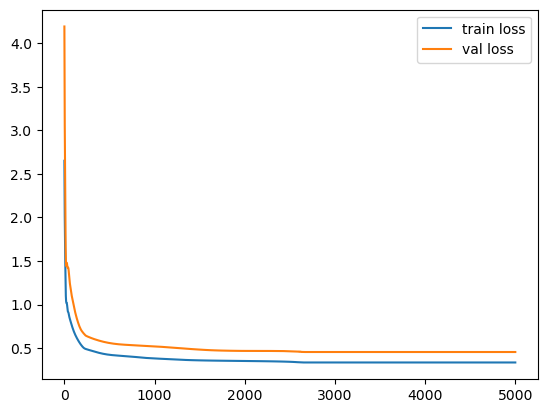

In [133]:
plot_history(grid_search_results[17]['history'])

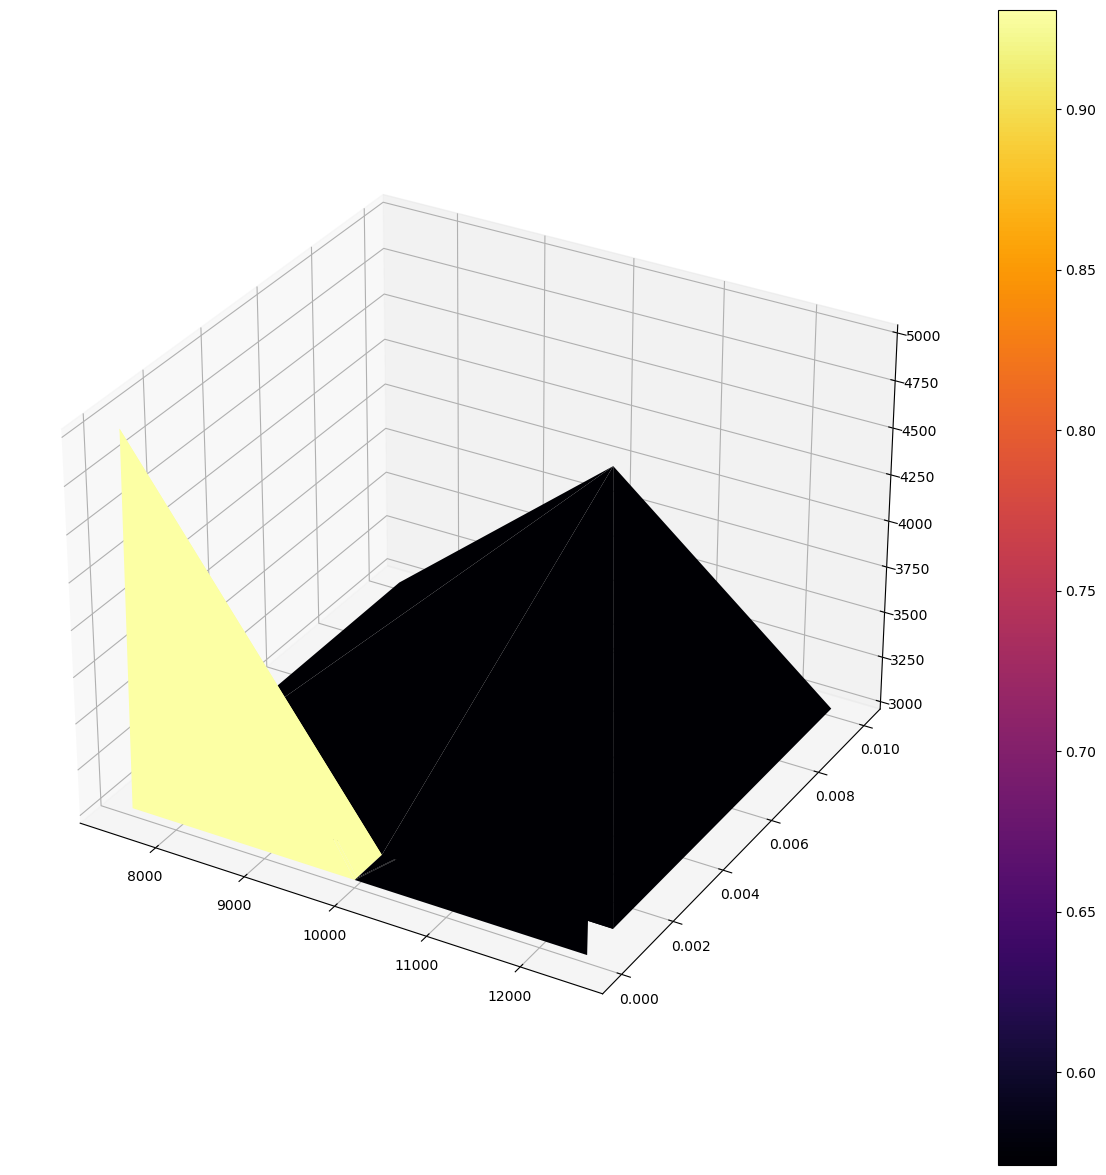

In [134]:
tv = results[:,0]
l1 = results[:,1]
epochs = results[:,2]
ssim = results[:,3]

fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection="3d")

# Creating plot
#ax.scatter3D(tv, l1, epochs, c=ssim, cmap=plt.hot())
scamap = plt.cm.ScalarMappable(cmap='inferno')
fcolors = scamap.to_rgba(ssim)
ax.plot_trisurf(tv, l1, epochs, facecolors=fcolors, cmap='inferno')
fig.colorbar(scamap)

plt.show()

In [136]:
grid_search_results

[{'tv_coeff': 7500,
  'l1_coeff': 1e-05,
  'epochs': 3000,
  'history': <utils.loss_history at 0x22d078afe50>,
  'ssim': tensor(0.9225)},
 {'tv_coeff': 7500,
  'l1_coeff': 1e-05,
  'epochs': 4000,
  'history': <utils.loss_history at 0x22d078ca550>,
  'ssim': tensor(0.9226)},
 {'tv_coeff': 7500,
  'l1_coeff': 1e-05,
  'epochs': 5000,
  'history': <utils.loss_history at 0x22d07c49280>,
  'ssim': tensor(0.9247)},
 {'tv_coeff': 7500,
  'l1_coeff': 0.0001,
  'epochs': 3000,
  'history': <utils.loss_history at 0x22d07b66bb0>,
  'ssim': tensor(0.9054)},
 {'tv_coeff': 7500,
  'l1_coeff': 0.0001,
  'epochs': 4000,
  'history': <utils.loss_history at 0x22d08685340>,
  'ssim': tensor(0.5710)},
 {'tv_coeff': 7500,
  'l1_coeff': 0.0001,
  'epochs': 5000,
  'history': <utils.loss_history at 0x22d07d21220>,
  'ssim': tensor(0.7334)},
 {'tv_coeff': 7500,
  'l1_coeff': 0.001,
  'epochs': 3000,
  'history': <utils.loss_history at 0x22d08571b20>,
  'ssim': tensor(0.9194)},
 {'tv_coeff': 7500,
  'l1_coeff

In [145]:
#image_ = read_image('out_before.png')
image_ = images_lr[0]
image_ = image_[None,:]
ds_deblur_train = images_dataset(image_, image_)
ds_deblur_test = images_dataset(read_image('out_before.png')[None,:], (images_hr[0])[None,:])

BATCH_SIZE = 1

dl_deblur_train = DataLoader(ds_deblur_train,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
dl_deblur_test = DataLoader(ds_deblur_test,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

dl_deblur = {'train': dl_deblur_train, 'test': dl_deblur_test}


In [181]:
def loss_tv(y_pred, y_true):
    loss_tv_ = TVLoss()(y_pred)
    #loss_l1_ = nn.L1Loss()(y_pred, y_true)
    loss_l1_ = BRISQUELoss(data_range=255)(y_pred)
    #if loss_l1_ < 10:
    #    loss_l1_ = 0.
    #loss = 1000/loss_tv_ + 0.001*loss_l1_
    loss = 1/loss_tv_ + 100*loss_l1_
    return loss

def loss_fft(y_pred, y_true):
    loss = torch.sum(torch.abs(torch.fft.rfft(y_pred, 1)))
    loss = 10/loss + 0.001*nn.SmoothL1Loss()(y_pred, y_true)
    return loss   

def metric_ssim(y_pred, y_true):
    return ssim(y_pred, y_true, data_range=255)

model = nn_deblur(3)
torch.nn.init.xavier_uniform_(model.conv1[0].weight)
torch.nn.init.xavier_uniform_(model.conv1[1].weight)
torch.nn.init.xavier_uniform_(model.conv_resc1.weight)
model = model.to(device)
print (model)
criterion = loss_tv
optimizer = torch.optim.Adamax(model.parameters(), lr=1e-4)          
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,min_lr=1e-10)            
trainer = torch_trainer(model=model,
                                   criterion=criterion,
                                   optimizer=optimizer,
                                   epochs=2000,
                                   dataloader=dl_deblur,
                                   metrics=metric_ssim)
history = trainer.train()

nn_deblur(
  (conv1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  )
  (conv_resc1): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (act): GELU(approximate='none')
)
epoch 1/2000; train loss: 3582.9712, val_loss: 4838.2021; lr=0.0001;  metric=0.3586
epoch 2/2000; train loss: 3557.5195, val_loss: 4840.2529; lr=0.0001;  metric=0.3606
epoch 3/2000; train loss: 3552.9236, val_loss: 4849.2861; lr=0.0001;  metric=0.3625
epoch 4/2000; train loss: 3581.2439, val_loss: 4841.5225; lr=0.0001;  metric=0.3644
epoch 5/2000; train loss: 3545.7703, val_loss: 4857.6846; lr=0.0001;  metric=0.3662
epoch 6/2000; train loss: 3573.9380, val_loss: 4855.2920; lr=0.0001;  metric=0.3679
epoch 7/2000; train loss: 3534.2163, val_loss: 4850.4580; lr=0.0001;  metric=0.3696
epoch 8/2000; train loss: 3520.4407, val_loss: 4851.4834; lr=0.0001;  metric=0.3713
epoch 9/2000; train loss: 3497.668

KeyboardInterrupt: 

tensor(0.6029) tensor(0.9263)


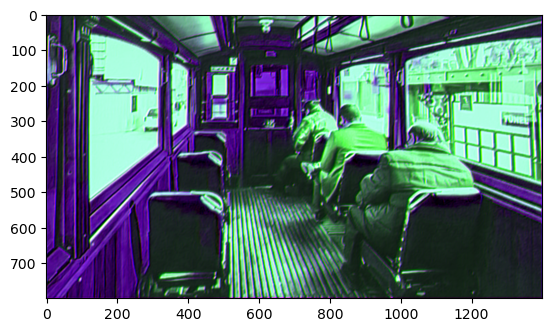

In [176]:
#test = images_lr[0]
test = read_image('out_before.png')
test = test[None, :]
model.eval()
with torch.no_grad():
    preds = model(test).type(torch.LongTensor)
img = preds[0].permute(1,2,0).detach()
to_save = (preds[0])/255.
torchvision.utils.save_image(to_save, 'out.png')
plt.imshow(img)

ref = images_hr[0]
ref = ref[None, :]
ssim_after = ssim(preds, ref, data_range=255)
ssim_before = ssim(test, ref, data_range=255)
print(ssim_after, ssim_before)

In [158]:
test = read_image('out.png')
test = test[None, :]
ref = images_hr[0]
ref = ref[None, :]

nn.CrossEntropyLoss()(test.type(torch.FloatTensor), ref.type(torch.FloatTensor))

tensor(7853.3550)

In [145]:
test = read_image('out_before.png')
test.shape

torch.Size([3, 800, 1400])

# ---------

In [ ]:
torch.save(model_deblur, 'ssim09282_1000epochs')
torch.save({
            'epoch': 1000,
            'model_state_dict': model_deblur.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion_deblur
            }, 'torch_ssim09282_1000epochs')

In [168]:
#model1 = nn_deblur(3)
model2 = torch.load('ssim09282_1000epochs')

In [169]:
print(model2)

nn_deblur(
  (conv1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  )
  (conv_resc): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (act): GELU(approximate='none')
)


tensor(0.9282) tensor(0.9263)


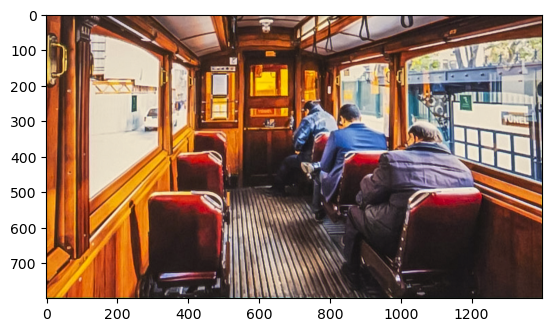

In [170]:
test = read_image('out_before.png')
test = test[None, :]
model2.eval()
with torch.no_grad():
    preds = model2(test).type(torch.LongTensor)
img = preds[0].permute(1,2,0).detach()
to_save = (preds[0])/255.
torchvision.utils.save_image(to_save, 'out1.png')
plt.imshow(img)

ref = images_hr[0]
ref = ref[None, :]
ssim_after = ssim(preds, ref, data_range=255)
ssim_before = ssim(test, ref, data_range=255)
print(ssim_after, ssim_before)